In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
# import Learn_Knonlinear as lka
import scipy
import scipy.linalg
from scipy.integrate import odeint
import sys
import os
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/utility/")
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/sizeNN_learnmodel_train/")
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/other_model/")
from Utility import data_collecter
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [2]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                "KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear"]
Method_names = ["KoopmanDerivative","KoopmanRBF",\
            "KDNN","KRNN","DKUC(ours)",\
            "DKAC(ours)","DKN(ours)",\
                "DKUC(no SOC)",\
            "DKAC(no SOC)","DKN(no SOC)"]

In [3]:
def eval_err(suffix,env_name,method_index,layer_i):
    # method_index = 0
    method = Methods[method_index]
    root_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+suffix
    print(method)
    #sys.path.append("control/train/")
    if  method_index==3:
        import Learn_Knonlinear_RNN as lka
    elif method_index==2:
        import Learn_Knonlinear as lka
    elif method_index==6:
        import learn_DKN_SOC_sizeNN as lka
    elif method_index==5:
        import learn_DKAC_SOC_sizeNN as lka
    elif method_index==4:
        import learn_DKUC_SOC_sizeNN as lka
    elif method_index==7:
        import Learn_DKUC_withoutSOC as lka
    elif method_index==8:
        import Learn_DKAC_withoutSOC as lka
    elif method_index==9:
        import Learn_DKN_withoutSOC as lka
    for file in os.listdir(root_path):
        if file.startswith(method+"_"+env_name+"layer{}".format(layer_i)+"_") and file.endswith(".pth"):
            model_path = file  
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstates = Data_collect.Nstates
    layer_depth = layer_i
    layer_width = 128
    dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))
    state_dict = dicts["model"]
    if method.endswith("KNonlinear"):
        Elayer = dicts["Elayer"]
        net = lka.Network(layers=Elayer,u_dim=udim)
    elif method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1)
    elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
        layer = dicts["layer"]
        blayer = dicts["blayer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,blayer,NKoopman,udim)
    elif method.endswith("KoopmanU"):
        layer = dicts["layer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,NKoopman,udim)  
    net.load_state_dict(state_dict)
    #device = torch.device("cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.cuda()
    net.double()
    Samples = 500
    steps = 1000
    random.seed(2022)
    np.random.seed(2022)
    times = 20
    max_loss_all = np.zeros((times,steps))
    mean_loss_all = np.zeros((times,steps))
    min_loss_all = np.zeros((times,steps))
    test_loss = []
    with torch.no_grad():
        for i in range(times):
            test_data_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+"method{}{}.npy".format(env_name,i)
            # if os.path.exists(test_data_path):
            #     test_data = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/{}{}.npy".format(env_name,i))
            # else:
            test_data = Data_collect.collect_koopman_data(Samples,steps)
            np.save("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+"method{}{}.npy".format(env_name,i),test_data)
            max_loss,mean_loss,min_loss = lka.K_loss(test_data,net,udim,Nstate=Nstates)
            max_loss_all[i] = max_loss.reshape(-1)
            mean_loss_all[i] = mean_loss.reshape(-1)
            test_loss.append(mean_loss.reshape(-1))
            min_loss_all[i] = min_loss.reshape(-1)
    max_mean = np.mean(max_loss_all,axis=0)
    max_std = np.std(max_loss_all,axis=0)
    mean_mean =  np.mean(mean_loss_all,axis=0)
    mean_std =  np.std(mean_loss_all,axis=0)
    min_mean =  np.mean(min_loss_all,axis=0)
    min_std =  np.std(min_loss_all,axis=0)  
    test_loss = np.array(test_loss)  
    print("test_loss:{}".format(test_loss.shape))
    np.save("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+env_name+"_"+method+"layer1{}{}.npy".format(layer_i, steps),np.array([max_mean,max_std,mean_mean,mean_std,min_mean,min_std]))
    np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/"+env_name+"{}".format(method_index)+"_{}.npy".format(steps),test_loss)
    return max_mean,max_std,mean_mean,mean_std,min_mean,min_std

In [4]:
#suffix = "compare_DKAC_sizeNN_30"
#suffix = "DKUC_SOC_sizeNN"
#suffix = "DKN_SOC_sizeNN"
suffix = ["*","*","Knolinear_SOC_models","KRNN_SOC_models","DKUC_SOC_sizeNN","compare_DKAC_sizeNN_30","DKN_SOC_sizeNN","DKUC_withoutSOC_sizeNN","DKAC_withoutSOC_sizeNN","DKN_withoutSOC_sizeNN"]
env_name = "DampingPendulum"

# env_name = "MountainCarContinuous-v0"
# env_name = "CartPole-v1"
# env_name = "Pendulum-v1"
# method_index = 3
# method = Methods[method_index]
steps = 1000
for i in range(9,10):
    if i==6 or i==2:
        pass
    else:
        eval_err(suffix[i],env_name,method_index=i,layer_i=4)

KoopmanNonlinear
test_loss:(20, 1000)


1.567e-03 ± 3.436e-03
2.980e-03 ± 6.531e-03
2.936e-03 ± 6.366e-03
4.072e-03 ± 8.836e-03
3.885e-03 ± 8.352e-03
4.604e-03 ± 9.891e-03
6.675e-03 ± 1.446e-02
6.741e-03 ± 1.454e-02
8.443e-03 ± 1.827e-02
1.109e-02 ± 2.413e-02
1.042e-02 ± 2.256e-02
1.101e-02 ± 2.382e-02
1.628e-02 ± 3.553e-02
2.435e-02 ± 5.350e-02
2.261e-02 ± 4.953e-02
3.275e-02 ± 7.212e-02
3.974e-02 ± 8.767e-02
4.980e-02 ± 1.101e-01
5.786e-02 ± 1.280e-01
6.357e-02 ± 1.407e-01
6.578e-02 ± 1.455e-01
7.672e-02 ± 1.699e-01
9.304e-02 ± 2.063e-01
1.148e-01 ± 2.548e-01
1.361e-01 ± 3.023e-01
1.384e-01 ± 3.073e-01
1.520e-01 ± 3.375e-01
1.664e-01 ± 3.694e-01
1.682e-01 ± 3.732e-01
2.012e-01 ± 4.468e-01
2.149e-01 ± 4.772e-01
2.491e-01 ± 5.532e-01
2.471e-01 ± 5.485e-01
2.625e-01 ± 5.826e-01
2.616e-01 ± 5.801e-01
2.733e-01 ± 6.057e-01
2.976e-01 ± 6.596e-01
2.958e-01 ± 6.551e-01
3.248e-01 ± 7.194e-01
3.195e-01 ± 7.069e-01
3.505e-01 ± 7.754e-01
3.568e-01 ± 7.890e-01
3.653e-01 ± 8.071e-01
3.791e-01 ± 8.372e-01
3.914e-01 ± 8.638e-01
4.050e-01 

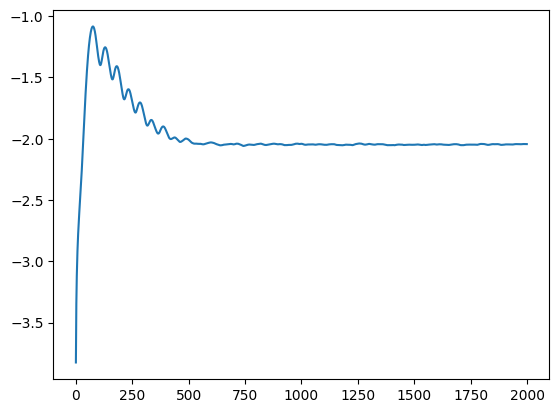

In [12]:
env_name = "DampingPendulum"
data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/{}".format(6)+"_{}.npy".format(200))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/Pendulum-v1{}".format(6)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/MountainCarContinuous-v0{}".format(6)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/CartPole-v1{}".format(6)+"_{}.npy".format(15))
Loss_Data = []
mean_data = []
for i in range(1000):#15
    data = data_all[:,i]
    # 计算平均值和标准差
    mean_value = sum(data) / len(data)
    std_deviation = (sum((x - mean_value) ** 2 for x in data) / len(data)) ** 0.5

    # 使用科学计数法格式化字符串
    formatted_string = "{:.3e} ± {:.3e}".format(mean_value, std_deviation)
    Loss_Data.append(formatted_string)
    print(formatted_string)
    mean_data.append(mean_value)
Loss_Data = np.array(Loss_Data)
mean_data = np.array(mean_data)
print(Loss_Data[9],Loss_Data[49],Loss_Data[99],Loss_Data[199])
#np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/DKN_200step_loss.npy",Loss_Data)
#np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/6_1000step_loss.npy",data_all[2])

9.137e-04 ± 3.024e-05
1.390e-03 ± 4.807e-05
1.859e-03 ± 6.516e-05
2.318e-03 ± 1.169e-04
2.787e-03 ± 1.248e-04
3.269e-03 ± 1.275e-04
3.766e-03 ± 1.467e-04
4.266e-03 ± 1.615e-04
4.820e-03 ± 1.675e-04
5.396e-03 ± 1.711e-04
5.997e-03 ± 1.882e-04
6.665e-03 ± 2.023e-04
7.346e-03 ± 2.109e-04
8.127e-03 ± 2.156e-04
8.973e-03 ± 2.293e-04
9.880e-03 ± 2.469e-04
1.086e-02 ± 2.781e-04
1.189e-02 ± 2.832e-04
1.298e-02 ± 3.333e-04
1.415e-02 ± 3.826e-04
1.544e-02 ± 4.327e-04
1.683e-02 ± 4.991e-04
1.838e-02 ± 5.878e-04
2.009e-02 ± 7.126e-04
2.197e-02 ± 8.210e-04
2.398e-02 ± 9.042e-04
2.615e-02 ± 9.762e-04
2.849e-02 ± 1.074e-03
3.097e-02 ± 1.177e-03
3.361e-02 ± 1.298e-03
3.645e-02 ± 1.412e-03
3.951e-02 ± 1.522e-03
4.283e-02 ± 1.616e-03
4.641e-02 ± 1.727e-03
5.029e-02 ± 1.845e-03
5.456e-02 ± 2.002e-03
5.921e-02 ± 2.183e-03
6.428e-02 ± 2.369e-03
6.983e-02 ± 2.600e-03
7.596e-02 ± 2.910e-03
8.275e-02 ± 3.289e-03
9.018e-02 ± 3.722e-03
9.830e-02 ± 4.218e-03
1.071e-01 ± 4.749e-03
1.167e-01 ± 5.293e-03
1.269e-01 

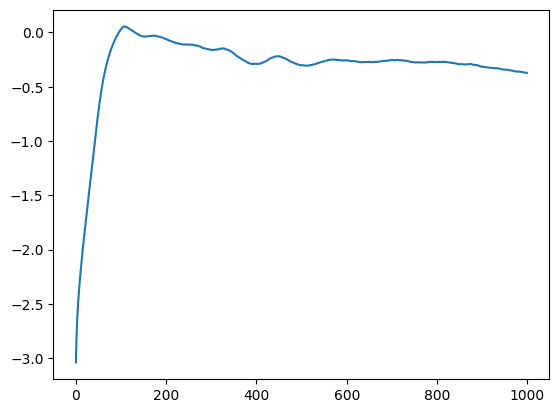

In [13]:
steps = 1000
data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/DampingPendulum{}".format(5)+"_{}.npy".format(steps))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/Pendulum-v1{}".format(5)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/MountainCarContinuous-v0{}".format(5)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/CartPole-v1{}".format(5)+"_{}.npy".format(15))
Loss_Data = []
mean_data = []
for i in range(steps):#15
    data = data_all[:,i]
    # 计算平均值和标准差
    mean_value = sum(data) / len(data)
    std_deviation = (sum((x - mean_value) ** 2 for x in data) / len(data)) ** 0.5

    # 使用科学计数法格式化字符串
    formatted_string = "{:.3e} ± {:.3e}".format(mean_value, std_deviation)
    Loss_Data.append(formatted_string)
    print(formatted_string)
    mean_data.append(mean_value)
Loss_Data = np.array(Loss_Data)
mean_data = np.array(mean_data)
print(Loss_Data[9],Loss_Data[49],Loss_Data[99],Loss_Data[199])
plt.plot(np.log10(mean_data))
#np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/DKAC_200step_loss.npy",Loss_Data)
np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/5_1000step_loss.npy",mean_data)

7.289e-04 ± 2.741e-05
1.930e-03 ± 7.700e-05
3.368e-03 ± 1.419e-04
5.004e-03 ± 1.973e-04
6.817e-03 ± 2.760e-04
8.776e-03 ± 3.812e-04
1.088e-02 ± 4.721e-04
1.311e-02 ± 5.587e-04
1.545e-02 ± 6.544e-04
1.793e-02 ± 7.401e-04
2.053e-02 ± 8.220e-04
2.328e-02 ± 9.210e-04
2.614e-02 ± 1.034e-03
2.913e-02 ± 1.164e-03
3.227e-02 ± 1.299e-03
3.557e-02 ± 1.439e-03
3.903e-02 ± 1.591e-03
4.268e-02 ± 1.743e-03
4.653e-02 ± 1.887e-03
5.062e-02 ± 2.028e-03
5.502e-02 ± 2.143e-03
5.980e-02 ± 2.219e-03
6.499e-02 ± 2.274e-03
7.068e-02 ± 2.388e-03
7.689e-02 ± 2.536e-03
8.364e-02 ± 2.711e-03
9.103e-02 ± 2.969e-03
9.911e-02 ± 3.289e-03
1.079e-01 ± 3.644e-03
1.175e-01 ± 3.993e-03
1.278e-01 ± 4.339e-03
1.389e-01 ± 4.692e-03
1.509e-01 ± 5.059e-03
1.637e-01 ± 5.443e-03
1.774e-01 ± 5.840e-03
1.919e-01 ± 6.276e-03
2.072e-01 ± 6.765e-03
2.234e-01 ± 7.286e-03
2.404e-01 ± 7.832e-03
2.582e-01 ± 8.414e-03
2.767e-01 ± 9.050e-03
2.960e-01 ± 9.725e-03
3.161e-01 ± 1.046e-02
3.369e-01 ± 1.125e-02
3.582e-01 ± 1.211e-02
3.802e-01 

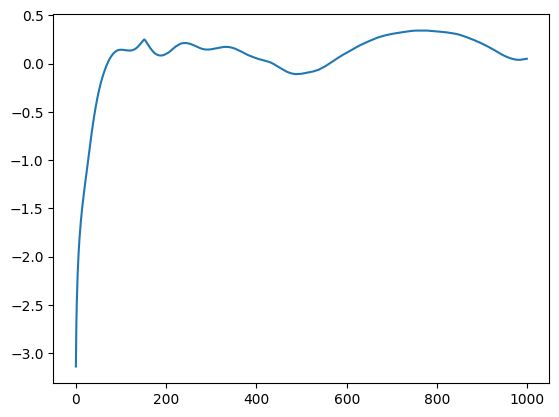

In [15]:
data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/DampingPendulum{}".format(4)+"_{}.npy".format(steps))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/Pendulum-v1{}".format(4)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/MountainCarContinuous-v0{}".format(4)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/CartPole-v1{}".format(4)+"_{}.npy".format(15))
Loss_Data = []
mean_data = []
for i in range(steps):#15
    data = data_all[:,i]
    # 计算平均值和标准差
    mean_value = sum(data) / len(data)
    std_deviation = (sum((x - mean_value) ** 2 for x in data) / len(data)) ** 0.5

    # 使用科学计数法格式化字符串
    formatted_string = "{:.3e} ± {:.3e}".format(mean_value, std_deviation)
    Loss_Data.append(formatted_string)
    print(formatted_string)
    mean_data.append(mean_value)
Loss_Data = np.array(Loss_Data)
mean_data = np.array(mean_data)
print(Loss_Data[9],Loss_Data[49],Loss_Data[99],Loss_Data[199])
plt.plot(np.log10(mean_data))
#np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/DKUC_200step_loss.npy",Loss_Data)
np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/4_1000step_loss.npy",mean_data)

2.437e-02 ± 7.827e-04
2.376e-02 ± 6.153e-04
2.351e-02 ± 6.853e-04
2.336e-02 ± 7.315e-04
2.310e-02 ± 6.553e-04
2.317e-02 ± 6.581e-04
2.311e-02 ± 6.521e-04
2.309e-02 ± 6.535e-04
2.312e-02 ± 5.838e-04
2.330e-02 ± 6.057e-04
2.338e-02 ± 6.614e-04
2.370e-02 ± 5.537e-04
2.408e-02 ± 7.299e-04
2.438e-02 ± 8.535e-04
2.489e-02 ± 1.037e-03
2.532e-02 ± 1.188e-03
2.583e-02 ± 1.252e-03
2.677e-02 ± 1.225e-03
2.745e-02 ± 1.543e-03
2.829e-02 ± 1.935e-03
2.906e-02 ± 2.281e-03
3.001e-02 ± 2.256e-03
3.103e-02 ± 2.518e-03
3.198e-02 ± 2.557e-03
3.304e-02 ± 2.490e-03
3.408e-02 ± 2.942e-03
3.507e-02 ± 2.648e-03
3.615e-02 ± 3.258e-03
3.737e-02 ± 3.285e-03
3.856e-02 ± 3.403e-03
3.947e-02 ± 3.296e-03
4.061e-02 ± 3.262e-03
4.203e-02 ± 3.850e-03
4.271e-02 ± 3.418e-03
4.355e-02 ± 3.821e-03
4.490e-02 ± 3.751e-03
4.571e-02 ± 3.725e-03
4.648e-02 ± 3.844e-03
4.726e-02 ± 3.746e-03
4.847e-02 ± 4.036e-03
4.894e-02 ± 3.769e-03
4.981e-02 ± 3.625e-03
5.020e-02 ± 4.264e-03
5.113e-02 ± 4.145e-03
5.122e-02 ± 3.945e-03
5.159e-02 

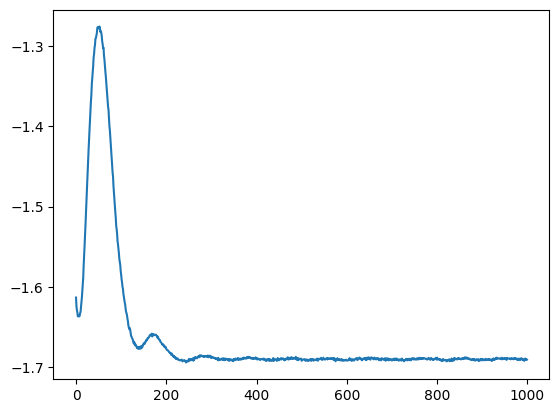

In [16]:
data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/DampingPendulum{}".format(3)+"_{}.npy".format(steps))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/Pendulum-v1{}".format(3)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/MountainCarContinuous-v0{}".format(3)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/CartPole-v1{}".format(3)+"_{}.npy".format(15))
Loss_Data = []
mean_data = []
for i in range(steps):#15
    data = data_all[:,i]
    # 计算平均值和标准差
    mean_value = sum(data) / len(data)
    std_deviation = (sum((x - mean_value) ** 2 for x in data) / len(data)) ** 0.5

    # 使用科学计数法格式化字符串
    formatted_string = "{:.3e} ± {:.3e}".format(mean_value, std_deviation)
    Loss_Data.append(formatted_string)
    print(formatted_string)
    mean_data.append(mean_value)
Loss_Data = np.array(Loss_Data)
mean_data = np.array(mean_data)
print(Loss_Data[9],Loss_Data[49],Loss_Data[99],Loss_Data[199])
plt.plot(np.log10(mean_data))
#np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/KRNN_200step_loss.npy",Loss_Data)
np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/3_1000step_loss.npy",mean_data)

1.630e-02 ± 1.433e-04
2.563e-02 ± 1.868e-04
3.393e-02 ± 2.920e-04
4.177e-02 ± 3.537e-04
4.937e-02 ± 4.301e-04
5.683e-02 ± 4.625e-04
6.430e-02 ± 5.024e-04
7.184e-02 ± 5.972e-04
7.956e-02 ± 7.008e-04
8.742e-02 ± 7.344e-04
9.549e-02 ± 8.830e-04
1.038e-01 ± 9.148e-04
1.124e-01 ± 1.033e-03
1.213e-01 ± 1.154e-03
1.303e-01 ± 1.328e-03
1.396e-01 ± 1.425e-03
1.490e-01 ± 1.483e-03
1.587e-01 ± 1.593e-03
1.686e-01 ± 1.683e-03
1.785e-01 ± 1.819e-03
1.887e-01 ± 1.964e-03
1.991e-01 ± 2.072e-03
2.095e-01 ± 2.166e-03
2.201e-01 ± 2.211e-03
2.306e-01 ± 2.370e-03
2.412e-01 ± 2.584e-03
2.519e-01 ± 2.748e-03
2.627e-01 ± 2.896e-03
2.734e-01 ± 2.994e-03
2.840e-01 ± 3.174e-03
2.946e-01 ± 3.243e-03
3.052e-01 ± 3.336e-03
3.156e-01 ± 3.464e-03
3.261e-01 ± 3.559e-03
3.363e-01 ± 3.828e-03
3.466e-01 ± 3.910e-03
3.569e-01 ± 4.067e-03
3.670e-01 ± 4.159e-03
3.770e-01 ± 4.459e-03
3.872e-01 ± 4.621e-03
3.972e-01 ± 4.558e-03
4.071e-01 ± 4.721e-03
4.172e-01 ± 4.766e-03
4.272e-01 ± 4.985e-03
4.374e-01 ± 5.073e-03
4.477e-01 

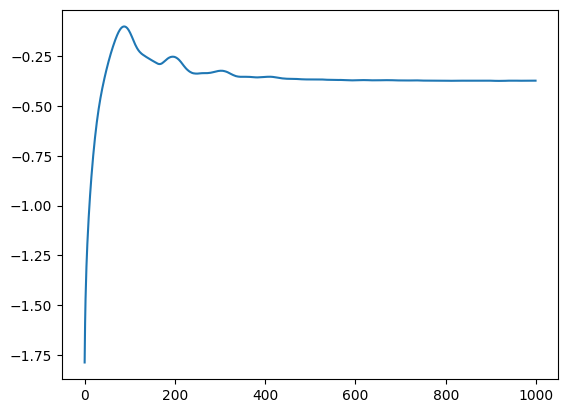

In [18]:
data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/DampingPendulum{}".format(2)+"_{}.npy".format(2000))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/Pendulum-v1{}".format(2)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/MountainCarContinuous-v0{}".format(2)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/CartPole-v1{}".format(2)+"_{}.npy".format(15))
# env_name = "DampingPendulum"
# env_name = "MountainCarContinuous-v0"
#env_name = "CartPole-v1"
#env_name = "Pendulum-v1"
Loss_Data = []
mean_data = []
for i in range(steps):#15
    data = data_all[:,i]
    # 计算平均值和标准差
    mean_value = sum(data) / len(data)
    std_deviation = (sum((x - mean_value) ** 2 for x in data) / len(data)) ** 0.5

    # 使用科学计数法格式化字符串
    formatted_string = "{:.3e} ± {:.3e}".format(mean_value, std_deviation)
    Loss_Data.append(formatted_string)
    print(formatted_string)
    mean_data.append(mean_value)
Loss_Data = np.array(Loss_Data)
mean_data = np.array(mean_data)
print(Loss_Data[9],Loss_Data[49],Loss_Data[99],Loss_Data[199])
plt.plot(np.log10(mean_data))
#np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/KNN_200step_loss.npy",Loss_Data)
np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/2_1000step_loss.npy",mean_data)

3.196e-02 ± 9.572e-04
4.409e-02 ± 1.719e-03
5.418e-02 ± 2.075e-03
6.458e-02 ± 2.772e-03
7.233e-02 ± 2.705e-03
7.962e-02 ± 2.715e-03
8.608e-02 ± 2.842e-03
9.363e-02 ± 3.204e-03
1.005e-01 ± 3.126e-03
1.092e-01 ± 2.848e-03
1.184e-01 ± 2.734e-03
1.294e-01 ± 3.160e-03
1.416e-01 ± 3.965e-03
1.571e-01 ± 4.522e-03
1.754e-01 ± 5.031e-03
1.969e-01 ± 5.784e-03
2.215e-01 ± 7.179e-03
2.491e-01 ± 8.431e-03
2.801e-01 ± 9.281e-03
3.132e-01 ± 1.015e-02
3.482e-01 ± 1.140e-02
3.856e-01 ± 1.225e-02
4.250e-01 ± 1.335e-02
4.666e-01 ± 1.447e-02
5.095e-01 ± 1.545e-02
5.528e-01 ± 1.648e-02
5.979e-01 ± 1.710e-02
6.438e-01 ± 1.768e-02
6.903e-01 ± 1.815e-02
7.369e-01 ± 1.843e-02
7.835e-01 ± 1.850e-02
8.296e-01 ± 1.879e-02
8.749e-01 ± 1.921e-02
9.206e-01 ± 2.010e-02
9.659e-01 ± 2.027e-02
1.011e+00 ± 2.026e-02
1.055e+00 ± 2.046e-02
1.099e+00 ± 2.042e-02
1.141e+00 ± 2.043e-02
1.182e+00 ± 2.054e-02
1.223e+00 ± 2.047e-02
1.262e+00 ± 2.084e-02
1.300e+00 ± 2.135e-02
1.337e+00 ± 2.152e-02
1.373e+00 ± 2.166e-02
1.408e+00 

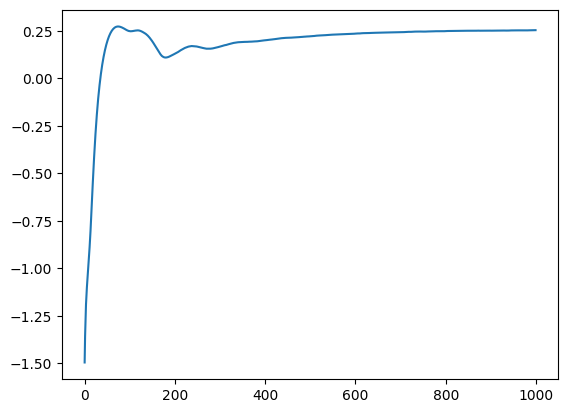

In [19]:
data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/DampingPendulum{}".format(7)+"_{}.npy".format(steps))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/Pendulum-v1{}".format(7)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/MountainCarContinuous-v0{}".format(7)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/CartPole-v1{}".format(7)+"_{}.npy".format(15))
# env_name = "DampingPendulum"
# env_name = "MountainCarContinuous-v0"
#env_name = "CartPole-v1"
#env_name = "Pendulum-v1"
Loss_Data = []
mean_data = []
for i in range(steps):#15
    data = data_all[:,i]
    # 计算平均值和标准差
    mean_value = sum(data) / len(data)
    std_deviation = (sum((x - mean_value) ** 2 for x in data) / len(data)) ** 0.5

    # 使用科学计数法格式化字符串
    formatted_string = "{:.3e} ± {:.3e}".format(mean_value, std_deviation)
    Loss_Data.append(formatted_string)
    print(formatted_string)
    mean_data.append(mean_value)
Loss_Data = np.array(Loss_Data)
mean_data = np.array(mean_data)
print(Loss_Data[9],Loss_Data[49],Loss_Data[99],Loss_Data[199])
plt.plot(np.log10(mean_data))
#np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/KNN_200step_loss.npy",Loss_Data)
np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/7_1000step_loss.npy",mean_data)

2.422e-02 ± 5.798e-04
2.766e-02 ± 6.458e-04
2.850e-02 ± 6.112e-04
2.351e-02 ± 5.051e-04
2.547e-02 ± 6.174e-04
2.510e-02 ± 5.448e-04
2.493e-02 ± 4.876e-04
2.752e-02 ± 5.042e-04
2.917e-02 ± 6.069e-04
3.179e-02 ± 7.392e-04
3.434e-02 ± 8.317e-04
3.784e-02 ± 9.823e-04
4.130e-02 ± 1.120e-03
4.484e-02 ± 1.135e-03
4.904e-02 ± 1.277e-03
5.410e-02 ± 1.515e-03
6.090e-02 ± 1.698e-03
6.918e-02 ± 1.902e-03
7.884e-02 ± 2.349e-03
8.982e-02 ± 2.672e-03
1.024e-01 ± 3.333e-03
1.168e-01 ± 3.900e-03
1.329e-01 ± 4.372e-03
1.507e-01 ± 5.049e-03
1.703e-01 ± 5.549e-03
1.919e-01 ± 6.264e-03
2.150e-01 ± 6.718e-03
2.399e-01 ± 7.250e-03
2.664e-01 ± 7.964e-03
2.945e-01 ± 8.760e-03
3.238e-01 ± 9.496e-03
3.545e-01 ± 1.012e-02
3.864e-01 ± 1.096e-02
4.190e-01 ± 1.225e-02
4.526e-01 ± 1.282e-02
4.860e-01 ± 1.375e-02
5.190e-01 ± 1.467e-02
5.532e-01 ± 1.590e-02
5.878e-01 ± 1.726e-02
6.224e-01 ± 1.852e-02
6.570e-01 ± 1.984e-02
6.912e-01 ± 2.098e-02
7.251e-01 ± 2.229e-02
7.591e-01 ± 2.347e-02
7.925e-01 ± 2.508e-02
8.256e-01 

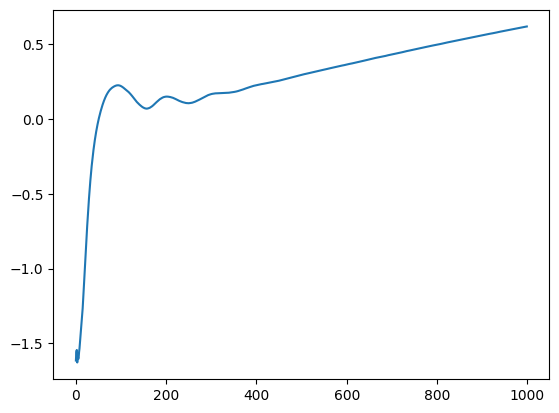

In [20]:
data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/DampingPendulum{}".format(8)+"_{}.npy".format(steps))#15
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/Pendulum-v1{}".format(8)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/MountainCarContinuous-v0{}".format(8)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/CartPole-v1{}".format(8)+"_{}.npy".format(15))
# env_name = "DampingPendulum"
# env_name = "MountainCarContinuous-v0"
#env_name = "CartPole-v1"
#env_name = "Pendulum-v1"
Loss_Data = []
mean_data = []
for i in range(steps):#15
    data = data_all[:,i]
    # 计算平均值和标准差
    mean_value = sum(data) / len(data)
    std_deviation = (sum((x - mean_value) ** 2 for x in data) / len(data)) ** 0.5

    # 使用科学计数法格式化字符串
    formatted_string = "{:.3e} ± {:.3e}".format(mean_value, std_deviation)
    Loss_Data.append(formatted_string)
    print(formatted_string)
    mean_data.append(mean_value)
Loss_Data = np.array(Loss_Data)
mean_data = np.array(mean_data)
print(Loss_Data[9],Loss_Data[49],Loss_Data[99],Loss_Data[199])
plt.plot(np.log10(mean_data))
#np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/KNN_200step_loss.npy",Loss_Data)
np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/8_1000step_loss.npy",mean_data)

3.505e-02 ± 1.309e-03
3.985e-02 ± 1.375e-03
4.487e-02 ± 1.339e-03
4.980e-02 ± 1.798e-03
5.444e-02 ± 1.976e-03
5.974e-02 ± 1.991e-03
6.452e-02 ± 1.670e-03
6.808e-02 ± 2.048e-03
7.374e-02 ± 2.432e-03
7.867e-02 ± 2.681e-03
8.316e-02 ± 2.523e-03
8.827e-02 ± 2.484e-03
9.259e-02 ± 2.817e-03
9.666e-02 ± 2.324e-03
1.021e-01 ± 2.770e-03
1.062e-01 ± 2.973e-03
1.108e-01 ± 2.916e-03
1.154e-01 ± 2.460e-03
1.192e-01 ± 2.800e-03
1.239e-01 ± 3.224e-03
1.283e-01 ± 3.280e-03
1.338e-01 ± 3.139e-03
1.379e-01 ± 2.826e-03
1.431e-01 ± 2.955e-03
1.476e-01 ± 3.581e-03
1.518e-01 ± 4.378e-03
1.567e-01 ± 4.698e-03
1.616e-01 ± 5.339e-03
1.667e-01 ± 5.242e-03
1.714e-01 ± 5.708e-03
1.757e-01 ± 6.101e-03
1.810e-01 ± 6.389e-03
1.859e-01 ± 6.720e-03
1.907e-01 ± 6.451e-03
1.956e-01 ± 6.861e-03
2.008e-01 ± 7.364e-03
2.059e-01 ± 7.743e-03
2.112e-01 ± 8.164e-03
2.158e-01 ± 8.489e-03
2.208e-01 ± 8.483e-03
2.259e-01 ± 8.811e-03
2.316e-01 ± 9.192e-03
2.367e-01 ± 9.564e-03
2.418e-01 ± 9.739e-03
2.466e-01 ± 9.757e-03
2.515e-01 

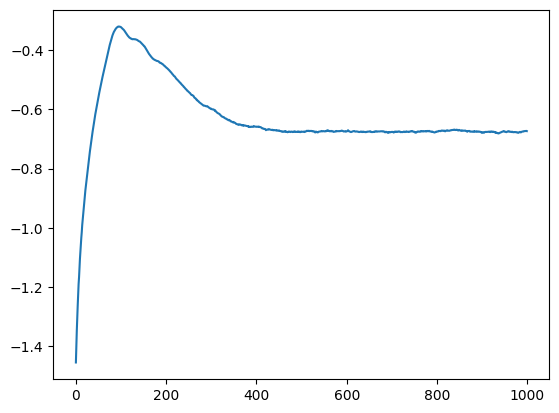

In [21]:
data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/DampingPendulum{}".format(9)+"_{}.npy".format(steps))#200
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/Pendulum-v1{}".format(9)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/MountainCarContinuous-v0{}".format(9)+"_{}.npy".format(15))
# data_all = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/CartPole-v1{}".format(9)+"_{}.npy".format(15))
# env_name = "DampingPendulum"
# env_name = "MountainCarContinuous-v0"
#env_name = "CartPole-v1"
#env_name = "Pendulum-v1"
Loss_Data = []
mean_data = []
for i in range(steps):#15
    data = data_all[:,i]
    # 计算平均值和标准差
    mean_value = sum(data) / len(data)
    std_deviation = (sum((x - mean_value) ** 2 for x in data) / len(data)) ** 0.5

    # 使用科学计数法格式化字符串
    formatted_string = "{:.3e} ± {:.3e}".format(mean_value, std_deviation)
    Loss_Data.append(formatted_string)
    print(formatted_string)
    mean_data.append(mean_value)
Loss_Data = np.array(Loss_Data)
mean_data = np.array(mean_data)
print(Loss_Data[9],Loss_Data[49],Loss_Data[99],Loss_Data[199])
plt.plot(np.log10(mean_data))
#np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/KNN_200step_loss.npy",Loss_Data)
np.save("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/9_1000step_loss.npy",mean_data)

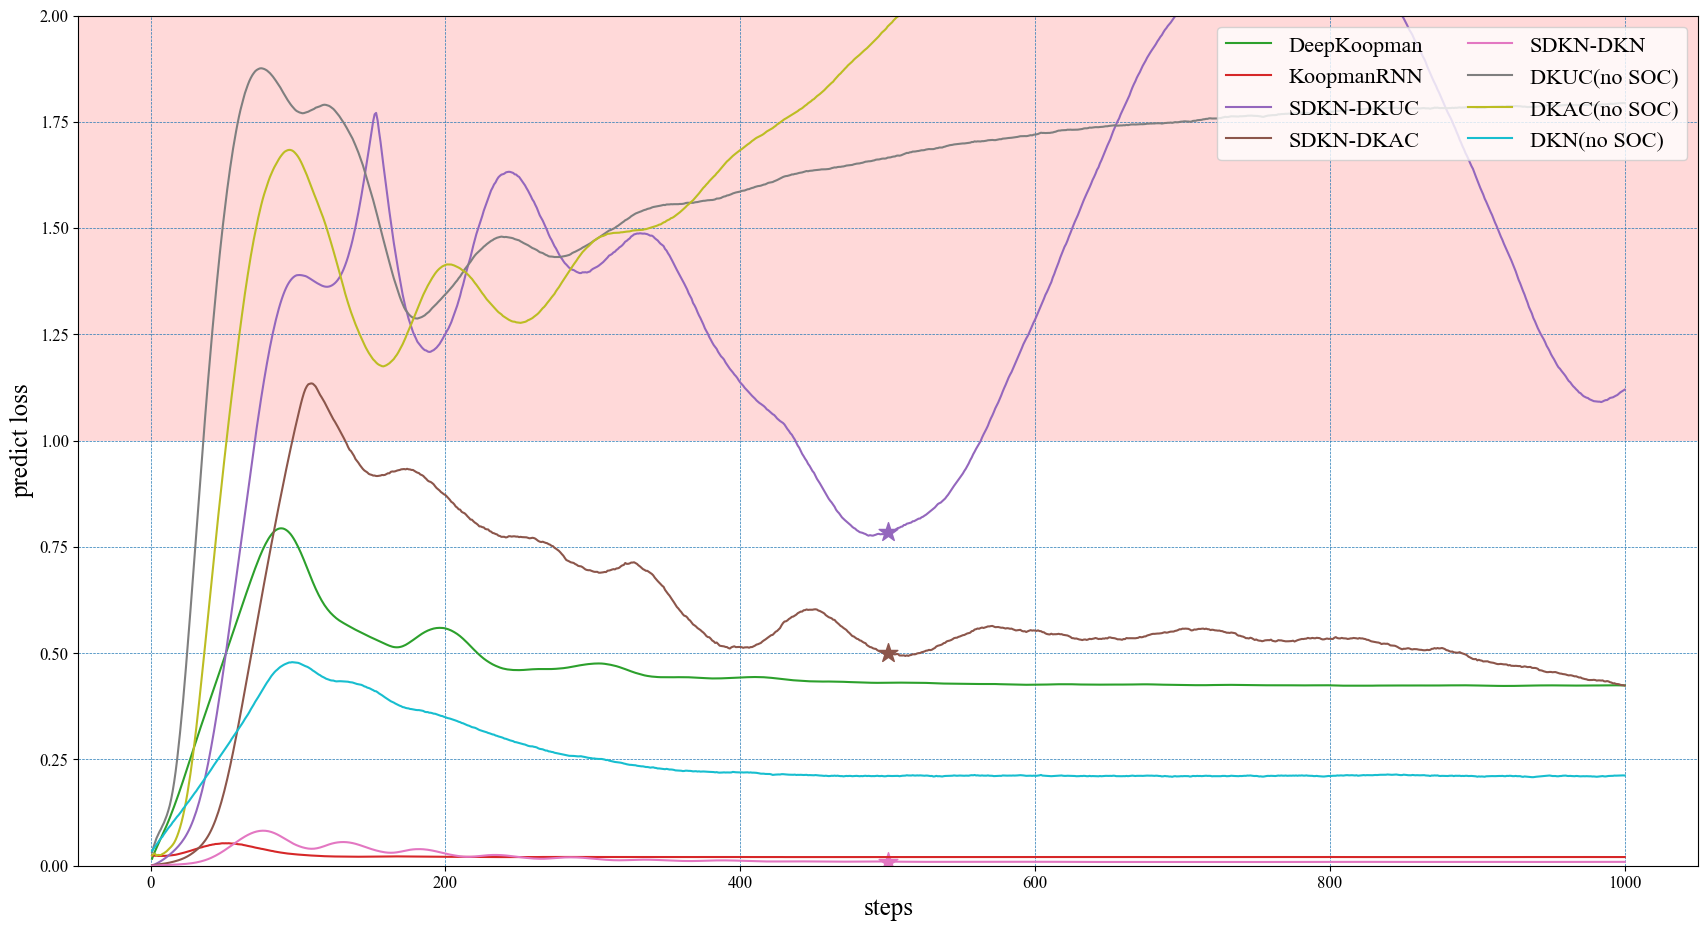

In [94]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size': 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 3
plt.rcParams['figure.subplot.left'] = 0.05
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['figure.subplot.bottom'] = 0.1
plt.rcParams['figure.subplot.top'] = 0.95 #子视图大小占视图的比例
plt.rcParams['savefig.dpi'] = 500 #图片像素
labels = ["*","*","DeepKoopman","KoopmanRNN","SDKN-DKUC","SDKN-DKAC","SDKN-DKN","DKUC(no SOC)","DKAC(no SOC)","DKN(no SOC)"]
plt.figure(figsize=(18, 10))
plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
env_name = "DampingPendulum"
title = env_name
compare = "mean"
T = []
for t in range(1000):
    T.append(t+1)
T = np.array(T)
for i in range(2,10):
    compare_data = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/model_compare_data/{}_1000step_loss.npy".format(i))
    plt.plot(T,compare_data[:1000],'-',color = colors[i],label=labels[i])#np.log10(data)
    if i==4 or i==5 or i==6:
        marked_indices = 500
        plt.scatter(T[marked_indices-1], compare_data[marked_indices], c=colors[i], marker='*',s=200)
    # 每隔10个数据点添加一个标记
    #marked_indices = np.arange(0, steps, 50)
    #plt.scatter(T[marked_indices], np.log10(data[2])[marked_indices], c=colors[i], marker='*')
# plt.axvspan(xmin=1, xmax=1000, alpha=0.32)
plt.axhspan(ymin=1, ymax=2, facecolor='red',alpha=0.15)
font_dict_text = {'family': 'serif', 'fontname': 'Times New Roman', 'color': 'black', 'weight': 'bold', 'size': 24}
# plt.text(800, 1.00, "unstable area",fontdict=font_dict_text)
plt.legend(loc = 'upper right', ncol=2 ,fontsize=16)
plt.grid(True, linestyle='--', color=colors[0], linewidth=0.5)
plt.xlabel("steps",fontsize=18)
plt.ylabel("predict loss",fontsize=18)
plt.ylim([0,2])
plt.savefig("D:/毕业设计/论文/pictures/SOC_short_predict/short/"+"SDKN-compare-1000.png",dpi = 500)

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size'   : 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 3
labels = ["*","*","BaseNet","KoopmanRNN","SDKN-DKUC","SDKN-DKAC","SDKN-DKN"]
plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
env_name = env_name
title = env_name
compare = "mean"
#method = Methods[2:]
# steps = 300
T = []
for t in range(steps):
    T.append(t+1)
T = np.array(T)
#plt.plot(np.log10(data[0]),'*-',color = colors[i],label="Layer Depth of NNs = {}".format(i+1),linewidth=1.5)
for i in range(4,5):
    method = Methods[i]
    file_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+env_name+"_"+Methods[i]+"layer1{}{}.npy".format(4, steps)
    data = np.load(file_path)
    plt.plot(T,np.log10(data[2]),'*-',color = colors[i],label=labels[i])#,linewidth=1.5
    # 每隔10个数据点添加一个标记
    #marked_indices = np.arange(0, steps, 50)
    #plt.scatter(T[marked_indices], np.log10(data[2])[marked_indices], c=colors[i], marker='*')
plt.legend(loc = 'lower right')
plt.grid(True)
# plt.grid(linestyle='-.')
plt.xlabel("Steps",fontsize=12)
plt.ylabel("Log Loss",fontsize=12)
plt.title(env_name,fontsize=20)
plt.savefig("D:/毕业设计/论文/pictures/SOC_compare_models/"+steps+env_name+"_models_"+compare+"_new1.png",dpi=500)

In [ ]:
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# font = {'size'   : 12}
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# mpl.rcParams['font.family'] = ['Times New Roman']
# mpl.rcParams["axes.titlepad"] = 16
# mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.markersize'] = 3
# mpl.rcParams['lines.markeredgecolor'] = 'black'
# mpl.rcParams['lines.markeredgewidth'] = '0.1'
# mpl.rcParams['xtick.bottom'] = False
# mpl.rcParams['ytick.left'] = False
# #plt.rcParams['figure.figsize'] = 4,3 #窗口大小
# plt.rcParams['figure.subplot.left'] = 0.1
# plt.rcParams['figure.subplot.right'] = 0.9
# plt.rcParams['figure.subplot.bottom'] = 0.25
# plt.rcParams['figure.subplot.top'] = 0.75 #子视图大小占视图的比例
# plt.rcParams['savefig.dpi'] = 500 #图片像素

# Method = ["KoopmanU","KoopmanNonlinearA"]#,"KoopmanNonlinear"
# plt.rc('font', **font)
# # markers = ['*','+','*','+','*','+','*']
# env_name = "DampingPendulum"
# # env_name = "CartPole-v1"
# #env_name = env_name
# # env_name = "Pendulum-v1"
# # env_name = "Franka"
# # env_name = "DoublePendulum"
# title = env_name
# #compare = "max"
# compare = "mean"
# fig, ax = plt.subplots(nrows=1, ncols=len(np.array(Method)), figsize=(4*len(np.array(Method)), 4))
# for p in range(len(np.array(Method))):
#     method = Method[p]
#     for i in range(5):
#         file_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+env_name+"_"+method+"layer1{}{}.npy".format(i+1, steps)
#         data = np.load(file_path)
#         ax[p].plot(np.log10(data[2]),'-',color = colors[i],label="Layer Depth = {}".format(i+1))#,linewidth=1.5
#     ax[p].set_title(method, x=0.5, y=-0.40)
#     ax[p].grid(True)
# plt.legend(bbox_to_anchor=(-1.28, -0.25),loc='upper center', ncol=5)
# plt.grid(True)
# # plt.grid(linestyle='-.')
# plt.xlabel("Steps",fontsize=12)
# plt.ylabel("Log Loss",fontsize=12)
# plt.title(title,fontsize=15)
# plt.savefig("D:/毕业设计/论文/pictures/SOC_sizeNN/"+env_name+"_"+method+"_allmean_"+compare+".png",dpi=500)